<a href="https://colab.research.google.com/github/MHusni1604/KKN-Periode-2/blob/main/training_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
# ===📦 Paket bawaan===
import os
import random
import shutil

# ===📊 Data dan visualisasi===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ===🖼️ Pemrosesan gambar===
from PIL import Image
import cv2

# ===🤖 TensorFlow & Keras===
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (
    InputLayer, Conv2D, SeparableConv2D, MaxPooling2D, MaxPool2D,
    Dense, Flatten, Dropout, BatchNormalization
)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import (
    ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau
)
from tensorflow.keras import Input
from keras.layers import TFSMLayer

# ===🧪 Utilities===
from sklearn.model_selection import train_test_split

# ===🌐 Kaggle Hub===
import kagglehub

In [13]:
path = kagglehub.dataset_download("huberthamelin/garbage-classification-labels-corrections")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/garbage-classification-labels-corrections


In [14]:
os.listdir(path)

['garbage_classification_enhanced',
 'labels_corrections.csv',
 'garbage_classification_corrected']

In [15]:
os.listdir(os.path.join(path, 'garbage_classification_enhanced'))

['metal',
 'white-glass',
 'biological',
 'paper',
 'brown-glass',
 'battery',
 'trash',
 'cardboard',
 'shoes',
 'clothes',
 'plastic',
 'green-glass']

In [16]:
folder = os.path.join(path, 'garbage_classification_enhanced')

class_names = os.listdir(folder)
print(class_names)

['metal', 'white-glass', 'biological', 'paper', 'brown-glass', 'battery', 'trash', 'cardboard', 'shoes', 'clothes', 'plastic', 'green-glass']


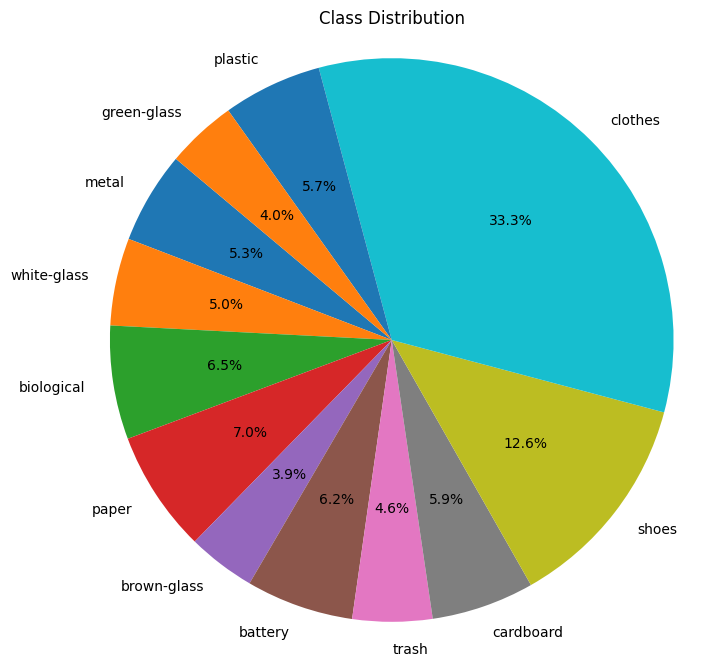

In [17]:
class_counts = []
for class_name in class_names:
    class_counts.append(len(os.listdir(os.path.join(folder, class_name))))

plt.figure(figsize=(8, 8))
plt.pie(class_counts, labels=class_names, autopct='%1.1f%%', startangle=140)
plt.title('Class Distribution')
plt.axis('equal')
plt.show()

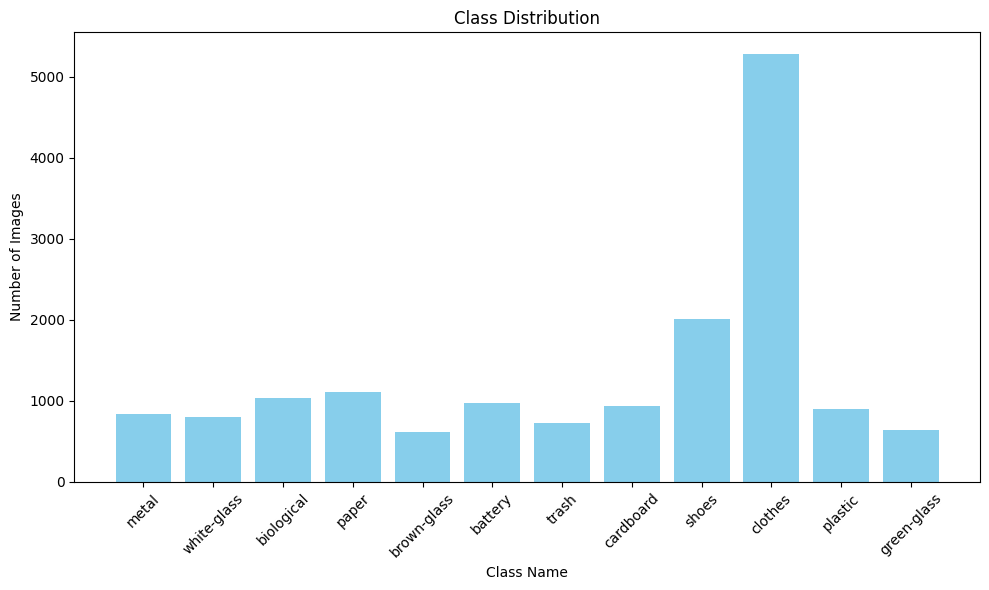

In [18]:
plt.figure(figsize=(10, 6))
plt.bar(class_names, class_counts, color='skyblue')
plt.xlabel('Class Name')
plt.ylabel('Number of Images')
plt.title('Class Distribution')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [19]:
!pip install bing-image-downloader

KeyboardInterrupt: 

In [ ]:
import os
from bing_image_downloader import downloader

# Konfigurasi dasar
class_names = ['cardboard', 'plastic', 'trash', 'clothes', 'battery', 'green-glass',
               'metal', 'shoes', 'white-glass', 'brown-glass', 'paper', 'biological']
folder = 'dataset'  # ganti sesuai folder dataset kamu
target_count = 5000

# Fungsi untuk menghitung jumlah gambar dalam folder kelas
def count_images(class_folder):
    if not os.path.exists(class_folder):
        return 0
    return len([f for f in os.listdir(class_folder) if os.path.isfile(os.path.join(class_folder, f))])

# Proses scraping
for class_name in class_names:
    class_path = os.path.join(folder, class_name)
    os.makedirs(class_path, exist_ok=True)

    current_count = count_images(class_path)
    remaining = target_count - current_count

    print(f"\n{class_name}: ada {current_count}, perlu tambah {remaining} gambar.")

    if remaining <= 0:
        continue  # skip kelas yang sudah memenuhi target

    keyword = class_name.replace('-', ' ')  # contoh: green-glass -> green glass

    # Scrape gambar secara bertahap, max 100 per batch (bisa kamu sesuaikan)
    batch = 0
    while remaining > 0:
        limit = min(remaining, 100)
        search_term = f"{keyword} waste" if class_name not in ['clothes', 'shoes'] else keyword
        output_dir = 'temp_download'

        print(f"Scraping '{search_term}' batch {batch + 1}, limit {limit}")

        downloader.download(search_term,
                            limit=limit,
                            output_dir=output_dir,
                            adult_filter_off=True,
                            force_replace=False,
                            timeout=60,
                            verbose=False)

        download_path = os.path.join(output_dir, search_term)
        if os.path.exists(download_path):
            files = os.listdir(download_path)
            for file in files:
                src = os.path.join(download_path, file)
                dst = os.path.join(class_path, f"{class_name}_{current_count}.jpg")
                os.rename(src, dst)
                current_count += 1
                remaining -= 1

            os.rmdir(download_path)
        batch += 1

# Hapus folder sementara
if os.path.exists('temp_download'):
    os.rmdir('temp_download')

print("\n✅ Semua kelas sudah memiliki 5000 gambar (atau lebih).")
